In [1]:
from util.SongDataStructure import *
from util.pitch_interval_estimation import *
import numpy as np
import json
from matplotlib import pyplot as plt
import os
from scipy.interpolate import interp1d
from models.vowel_modification_detector import vowel_mod_detector
vowel_mod = vowel_mod_detector()

## Input Block

In [4]:
dir = "E:/MASC/Structured_data/child_in_time"
dir = "/Volumes/EVAN_DISK/MASC/Structured_data/rolling_in_the_deep_adele"
file_name_template = "audio"
script_path = os.path.join(dir, "audio_full.TextGrid")
output_template = "jali_sing_2"
spike_width = 0.5

## Dicionaries and Constants and Functions

In [5]:
VOICED = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
CMU2VISEME = {"AA":"Ah", "AO":"Ah", "AY":"Ah", "AW":"Ah","AE":"Aa",
              "EY":"Aa","UH":"Uh", "UW":"U","IH": "Ih","IY": "Ih","EH": "Eh","HH": "Eh","UH": "Eh","AH": "Eh",
              "ER": "Eh","OW":"Oo","OY":"Oh","R":"R","D":"LNTD","T": "LNTD","L":"LNTD","N":"LNTD","NG":"LNTD",
              "F":"FV","V":"FV","B":"BP","M":"M","P":"BP","CH":"ShChZh","SH":"ShChZh","ZH":"ShChZh",
              "S": "SZ", "Z": "SZ","DH":"Th", "TH":"Th","G":"GK", "K":"GK","Y":"Y","JH":"J","W":"W",}
VOWELS_SLIDERS_JALI = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
CONSONANTS_SLIDERS_JALI = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"])
CONSONANTS_SLIDERS_NOJAW_JALI = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
JALI_SLIDERS_SET = set.union(VOWELS_SLIDERS_JALI, CONSONANTS_SLIDERS_JALI, CONSONANTS_SLIDERS_NOJAW_JALI)

In [6]:
class CMU_phonemes_dicts():
    def __init__(self):
        self.vocabs = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G',
                  'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH',
                  'UW', 'V', 'W', 'Y', 'Z', 'ZH'])
        self.vowels = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'ER', 'EY', 
                  'IH', 'IY', 'OW', 'OY', 'UH', 'UW', ])
        self.voiced = set(['M', 'N']).union(self.vowels)
        self.consonants = set(['B', 'CH', 'D', 'DH', 'F', 'G', 'HH', 'JH', 'K', 'L', 'M', 'N', 'NG', 
                              'P', 'R', 'S', 'SH', 'T', 'TH', 'V', 'W', 'Y', 'Z', 'ZH'])
        self.consonants_no_jaw = self.consonants
        self.lip_closer = set(["B", "F", "M", "P", "S", "V"])
        self.lip_rounder = set(["B", "F", "M", "P", "V"])
        self.nasal_obtruents = set(['L', 'N', 'NG', 'T', 'D', 'G', 'K', 'F', 'V', 'M', 'B', 'P'])
        self.fricative = set(["S", "Z", "ZH", "SH", "CH", "F", "V", 'TH'])
        self.plosive = set(["P", "B", "D", "T", "K", "G"])
        self.lip_heavy = set(["W", "OW", "UW", "S", "Z", "Y", "JH", "OY"])
        self.sibilant = set(["S", "Z", "SH", "CH", "ZH"])
class JALI_visemes_dicts():
     def __init__(self):
        self.vowels = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer"])
        self.voiced = set(['Ih_pointer', 'Ee_pointer', 'Eh_pointer', 'Aa_pointer', 'U_pointer', 'Uh_pointer'
                           , 'Oo_pointer', 'Oh_pointer', 'Schwa_pointer', 'Eu_pointer', "Ah_pointer", "LNTD_pointer", "LNTDa_pointer"])
        self.consonants_no_jaw = set(["Ya_pointer", "Ja_pointer", "Ra_pointer", "FVa_pointer", "LNTDa_pointer", "Ma_pointer", "BPa_pointer", "Wa_pointer", "Tha_pointer", "GKa_pointer"])
        self.consonants = set(["M_pointer", "BP_pointer", "JY_pointer", "Th_pointer", "ShChZh_pointer", "SZ_pointer", "GK_pointer", "LNTD_pointer", "R_pointer", "W_pointer", "FV_pointer"]) 
        self.lip_closer = set(["M_pointer", "BP_pointer", "FV_pointer", "SZ_pointer"])
        self.lip_rounder = set(["M_pointer", "BP_pointer", "FV_pointer"])
        self.vocabs = self.consonants.union(self.vowels).union(self.consonants_no_jaw)
        self.sibilant = set(["SZ_pointer", "ShChZh_pointer"])
        self.nasal_obtruents = set(["LNTD_pointer", "GK_pointer", "FV_pointer", "M_pointer", "BP_pointer"])
        self.fricative = set(["FV_pointer", "SZ_pointer", "ShChZh_pointer", "Th_pointer"])
        self.plosive = set(["BP_pointer", "LNTDa_pointer", "GK_pointer"])
        self.lip_heavy = set(["Oh_pointer", "W_pointer", "Wa_pointer", "U_pointer", "SZ_pointer", "JY_pointer",
                             "Ya_pointer", "Ja_pointer"])
        self.lip_rounder_to_no_jaw_dict = {"M_pointer":"Ma_pointer", "BP_pointer":"BPa_pointer", "FV_pointer":"FVa_pointer"}
cmu_sets = CMU_phonemes_dicts()
jali_sets = JALI_visemes_dicts()

In [7]:
def generate_basic_viseme_curve(start, end, value, sustain=1, decay = 0.75, onset=0.1, offset=0):
    if end - start < 0.1:
        end = start + 0.1
    interval = []
    interval.append([start-onset, 0])
    # second point is when the belting starts 
    interval.append([start, 1 * value])
    # third point emphasizes decay, it happens 75% down the interval
    if sustain < 1:
        interval.append([start + sustain * (end - start), decay * value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    elif sustain == 1:
        interval.append([end, value])
        # last point is where the furrowing ends
        interval.append([end+offset, 0])
    return interval
def get_kth_neighbour(input_list, i, k):
    if i+k < 0 or i+k >= len(input_list):
        return None
    return input_list[i+k]

In [8]:
# using tanh function to get a smooth curve
def Viseme_A(peak=None, lowest=None):
    if not peak is None:
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    else:
        peak = 0.99
        lowest = 0.4
        total = np.log((1+peak)/(1-peak))/2
        b = np.log((1+lowest)/(1-lowest))/2
        a = total-b
    def fn(val, val_max, val_min, max_val = 10):
        val = (val - val_min) / (val_max - val_min)
#         print(val)
#         return (lowest + val * ((peak - lowest)))*max_val
        return np.tanh((val)*a+b) * max_val
#         return (np.exp(val * 8)/np.exp(8) * (peak-lowest) + lowest) * max_val
    return fn
viseme_A = Viseme_A()
# plt.plot(np.arange(0, 1, 0.01), viseme_A(np.arange(0, 1, 0.01), 1, 0))

## Start of Running

In [9]:
# load file for Jali
lyric = Minimal_song_data_structure(os.path.join(dir, file_name_template+".wav"), os.path.join(dir, file_name_template+".txt"),
                                                                                             script_path)

In [10]:
# break the thing into sentence structures (if possible)
sentences = []
current_sentence = []
for i in range(0, len(lyric.phoneme_list)):
    if lyric.phoneme_list[i] == "EOS_tag":
        sentences.append(current_sentence)
        current_sentence = []
    else:
        current_sentence.append(i)
        if i == len(lyric.phoneme_list) - 1:
            sentences.append(current_sentence)
sentences = sentences[1:] 
# sentence stores the indexes
if len(sentences) == 0:
    sentences = [list(range(0, len(lyric.phoneme_list)))]

In [11]:
phoneme_list = lyric.phoneme_list
phoneme_interval = lyric.phoneme_intervals

## Pass 1, Determine Animation Curve for all the vowels (without consideration for co-articulation)

In [12]:
# animate only vowels and see how it goes
viseme_list = []
viseme_intervals = []
pure_phoneme_list = []
max_activation = 8
# threshold_slope = 200 # for formants
threshold_slope = 80 # for pitch

for sentence in sentences:
    lyric.pitch.xs()[0]
    sentence_pitch_x, sentence_pitch_y = lyric.get_f_interval([max(phoneme_interval[sentence[0]][0], lyric.pitch.xs()[0]), 
                                                               phoneme_interval[sentence[-1]][1]])
    sentence_percentiles = np.nanpercentile(sentence_pitch_y, [5, 95])
    sentence_mean = sentence_pitch_y.mean()
    sentence_min = sentence_percentiles[0]
    sentence_max = sentence_percentiles[1]
    for i in range(0, len(sentence)):
        # skip the misc symbols in the sentence
        if phoneme_list[sentence[i]] != "EOL_tag" and phoneme_list[sentence[i]] != ">":
            pure_phoneme_list.append(phoneme_list[sentence[i]])
        if phoneme_list[sentence[i]] in VOICED:
            xI, yI = lyric.get_I_interval(phoneme_interval[sentence[i]])
            xf, yf = lyric.get_f_interval(phoneme_interval[sentence[i]])
            xF, yF = lyric.get_F1_interval(phoneme_interval[sentence[i]])
            length_of_interval = xI[-1] - xI[0] 
            if length_of_interval <= 0.30: # if the vowel is approximately a speech vowel, then it is handled like speech
                onset = 0.12
                offset = 0.12
                if phoneme_list[sentence[i]] in cmu_sets.lip_heavy:
                    onset = 0.16
                    offset = 0.16
                value = 7
                sustain = 0.75
                decay = 0.75
                curve = generate_basic_viseme_curve(phoneme_interval[sentence[i]][0], phoneme_interval[sentence[i]][1], value, sustain=sustain, 
                                            decay = decay, onset=onset, offset=offset)
                viseme_intervals.append(curve)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")
            else:
                onset = 0.12
                offset = 0.12
                if phoneme_list[sentence[i]] in cmu_sets.lip_heavy:
                    onset = 0.16
                    offset = 0.16
                control_pts = []
                vib = lyric.compute_vibrato_intervals(yf-savgol_filter(yf, 29, 1), xf, lyric.dt)
                vib_interval_indexs = lyric.get_subarrays_indexes_from_time_interval(vib, xf)
                for vib_int in vib_interval_indexs:
                    yf[vib_int[0]:vib_int[1]] = yf[vib_int[0]:vib_int[1]].mean()
                slopes_f, intervals_f = efficient_piece_wise_linear_intervals(xf, yf)
                kpx_f, kpy_f = get_key_points(xf, yf, intervals_f, slopes_f)
                # onset and offset of these would be the same as regular vowels 
                control_pts.append([phoneme_interval[sentence[i]][0] - onset, 0])
                
                # here I will determine the average pitch when singing this vowel. Which is used to 
                avg_pitch = 0
                total_weight = 0
                pitch_values = []
                for si in range(0, len(slopes_f)):
                    if abs(slopes_f[si]) <= threshold_slope:
                        avg_pitch = avg_pitch + (yf[intervals_f[si][0]] * (intervals_f[si][1] - intervals_f[si][0]))
                        pitch_values.append(yf[intervals_f[si][0]])
                        total_weight = total_weight + (intervals_f[si][1] - intervals_f[si][0])
                if avg_pitch == 0:
                        avg_pitch = yf.mean()
                        total_weight = 1
                pitch_values = np.array(pitch_values)
                avg_pitch = avg_pitch / total_weight
                
                # now find the first key point - i.e. the beginning of the first plateau
                # the first key point is defined as the point where a plateau first appears 
                # it can also be the first point that reaches the same pitch as the first plateau
                # this ensures that undetected vibrato will not mess up with the timing
                # and cause the mouth to open too slowly 
                start = 0
                for si in range(0, len(slopes_f)):
                    if abs(slopes_f[si]) <= threshold_slope:
                        interp_pitch = interp1d(kpx_f, kpy_f)
                        start = si
                        end_x_search = min(xf[intervals_f[si][0]], kpx_f[-1])
                        begin_x_search = xf[intervals_f[0][0]]
                        x_range = np.arange(begin_x_search, end_x_search, 0.01)
                        f_range = interp_pitch(x_range)
                        first_val = interp_pitch(xf[intervals_f[si][0]])
                        for ssi in range(0, x_range.shape[0]-1):
                            if ((f_range[ssi] < first_val) and  (f_range[ssi+1] >= first_val) 
                                or (f_range[ssi] >= first_val) and  (f_range[ssi+1] < first_val)):
                                end_x_search = x_range[ssi]
                                break
                        val0 = viseme_A(yf[intervals_f[si][0]], yf.max(), min(yf.min(), sentence_mean))
                        val1 = viseme_A((yf[intervals_f[si][1]] + yf[intervals_f[si][0]])/2, yf.max(), min(yf.min(), sentence_mean))

#                         dif = (xf[intervals_f[si][1]] - end_x_search) * 0.7
                        dif = max((xf[intervals_f[si][1]] - xf[intervals_f[si][0]]) * 0.8, xf[intervals_f[si][1]] - xf[intervals_f[si][0]]- 0.1)
                        control_pts.append([end_x_search, val0])
                        control_pts.append([xf[intervals_f[si][0]] + dif, val1])                 
                        break
                # now determine intermediate key-points that correlates with lipshape
                # will not have any of these pts
#                 for si in range(start+1, len(slopes_f)):
#                     val0 = viseme_A(yf[intervals_f[si][0]], yf.max(), min(yf.min(), sentence_mean))
#                     val1 = viseme_A((yf[intervals_f[si][1]] + yf[intervals_f[si][0]])/2, yf.max(), min(yf.min(), sentence_mean))
#                     dif = max((xf[intervals_f[si][1]] - xf[intervals_f[si][0]]) * 0.8, xf[intervals_f[si][1]] - xf[intervals_f[si][0]]- 0.1)
#                     if abs(slopes_f[si]) <= threshold_slope:
#                         control_pts.append([xf[intervals_f[si][0]], val0])
#                         control_pts.append([xf[intervals_f[si][0]] + dif, val1])
                    
                for si in range(len(slopes_f)-1, -1, -1):
                    if abs(slopes_f[si]) <= threshold_slope:
                        control_pts.append([xf[intervals_f[si][1]], viseme_A(yf[intervals_f[si][1]], 
                                                                             yf.max(), yf.min())])
                        break
                control_pts.append([phoneme_interval[sentence[i]][1] + offset, 0])
                viseme_intervals.append(control_pts)
                viseme_list.append(CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer")   
                
        ### Dealing with consonants here. I'm just going to insert them between without too much modification
        ### it will about the same as pure Jali
        elif phoneme_list[sentence[i]] in cmu_sets.consonants:
            onset = 0.12
            offset = 0.12
            if CMU2VISEME[phoneme_list[sentence[i]]] in jali_sets.nasal_obtruents and phoneme_interval[sentence[i]][1] - phoneme_interval[sentence[i]][0] > 1/20:
                viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"
            else:
                if phoneme_list[sentence[i]] == "HH" or phoneme_list[sentence[i]] in cmu_sets.sibilant:
                    viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "_pointer"
                else:
                    viseme_jali = CMU2VISEME[phoneme_list[sentence[i]]] + "a_pointer"
            if viseme_jali in jali_sets.lip_heavy:
                onset = 0.16
                offset = 0.16
            start = phoneme_interval[sentence[i]][0]
            end = phoneme_interval[sentence[i]][1]
            if (end - start) <= 0.1:
                value = 6
                sustain = 0.75
                decay = 0.75
            elif (end - start) <= 0.3:
                value = 6
                sustain = 0.75
                decay = 0.75
            else:
                value = 8
                sustain = 0.75
                decay = 0.75
            if phoneme_list[sentence[i]] in cmu_sets.lip_closer:
                value = 10
            viseme_curve = generate_basic_viseme_curve(start, end, value, sustain=sustain, decay=decay, onset=onset, offset=offset)
            viseme_list.append(viseme_jali)
            viseme_intervals.append(viseme_curve)   

/Users/evansamaa/anaconda3/envs/jali_sing/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice.
/Users/evansamaa/anaconda3/envs/jali_sing/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3.818715490399587
3.8207154903995866


## 2. Pass 2 for co-articupation

In [13]:
# enforce co-articulation rules of consonants
viseme_list_final = []
viseme_intervals_final = []
pure_phoneme_list_final = []
i = 0;

while i < len(viseme_list):
    increment = 1
    i_next = min(i + 1, len(viseme_list)-1)
    if (viseme_list[i_next] == viseme_list[i] or (pure_phoneme_list[i] == "HH" and pure_phoneme_list[i_next] in cmu_sets.vowels)
        and viseme_intervals[i][-1][0] >= viseme_intervals[i_next][0][0]):
        # remove repeated vowels or consonants
        viseme_list_final.append(viseme_list[i_next])
        int_curr = viseme_intervals[i]
        int_next = viseme_intervals[i_next]
        viseme_interval = [int_curr[0], [int_curr[1][0], max(int_curr[1][1], int_next[1][1])]]
        for interv in int_next[2:]:
            viseme_interval.append(interv)
        viseme_intervals_final.append(viseme_interval)
        pure_phoneme_list_final.append(pure_phoneme_list[i_next])
        if viseme_list[i_next] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i_next]])
            viseme_intervals_final.append(viseme_interval)
        increment = 2
        
    elif viseme_list[i] in jali_sets.lip_heavy:
        # if the viseme is a lip-heavy viseme, the it is voice simutaneously as nearby labial dental and bilabials 
        current_interval = viseme_intervals[i] 
        if not get_kth_neighbour(viseme_list, i, -1) is None:
            if current_interval[0][0] <= viseme_intervals[i-1][-1][0] - lyric.dt and viseme_intervals[i-1][-1][0] in jali_sets.lip_rounder:
                current_interval[0][0] = viseme_intervals[i-1][0][0]
                current_interval[1][0] = viseme_intervals[i-1][1][0]
        if not get_kth_neighbour(viseme_list, i, +1) is None:
            if current_interval[-1][0] <= viseme_intervals[i+1][0][0] - lyric.dt and viseme_intervals[i+1][-1][0] in jali_sets.lip_rounder:
                current_interval[2][0] = viseme_intervals[i+1][0][0]
                current_interval[3][0] = viseme_intervals[i+1][1][0]
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(current_interval)
        if viseme_list[i] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]])
            viseme_intervals_final.append(current_interval)
        pure_phoneme_list_final.append(pure_phoneme_list[i])
    else:
        viseme_list_final.append(viseme_list[i])
        viseme_intervals_final.append(viseme_intervals[i])
        if viseme_list[i] in jali_sets.lip_rounder:
            viseme_list_final.append(jali_sets.lip_rounder_no_jaw_dict[viseme_list[i]])
            viseme_intervals_final.append(viseme_intervals[i])
        pure_phoneme_list_final.append(pure_phoneme_list[i])
    i = i + increment

## 2.1 Cause Visemes to overlap between sentences

In [14]:
for i in range(0, len(viseme_list_final)-1):
    # re-order all the clips so that 
    if pure_phoneme_list_final[i] in cmu_sets.vowels:
        next_vowel = -1
        for si in range(i+1, len(viseme_list_final)):
            if pure_phoneme_list_final[si] in cmu_sets.vowels:
                next_vowel = si
                break
        if next_vowel > -1:
            interval_i = viseme_intervals_final[i]
            interval_i.sort(key=lambda x:x[0])
            interval_next = viseme_intervals_final[next_vowel]
            interval_next.sort(key=lambda x:x[0])
            if interval_i[-1][0] <= interval_next[0][0]:
                # there is no overlap 
                interval_i[-1][1] = interval_i[-2][1]/2
                interval_i.append([interval_next[0][0], interval_i[-1][1] * 0.75])
                interval_i.append([interval_next[1][0], 0])
                viseme_intervals_final[i] = interval_i

## 3. Vowel modification

In [15]:
vowel2Cardinal5 = {"Ah_pointer":0, "Aa_pointer":1, "Eh_pointer":1, "Ee_pointer":2, 
                 "Ih_pointer":2, "Oo_pointer":3, "Oh_pointer":3, "Uh_pointer":0, 
                  "U_pointer":4, "Eu_pointer":4}
vowel2Cardinal3 = {"Ah_pointer":0, "Aa_pointer":1, "Eh_pointer":1, "Ee_pointer":1, 
                 "Ih_pointer":1, "Oo_pointer":2, "Oh_pointer":2, "Uh_pointer":0, 
                  "U_pointer":2, "Eu_pointer":2}

control_direction_matrix_coarse = {0:{1:["Dimple", "Dimple", [0, 9]], 2:["Pucker", "Pucker", [0, 4]]},
                                  1:{0:["Pucker", "Pucker", [0, 3]], 2:["Pucker", "Pucker", [0, 4]]},
                                  2:{0:["self", "Lip Pucker", [0, -3]], 1:["self", "Lip Pucker", [0, -6],
                                                                          "Dimple", "Dimple", [0, 9]]}}

No handles with labels found to put in legend.


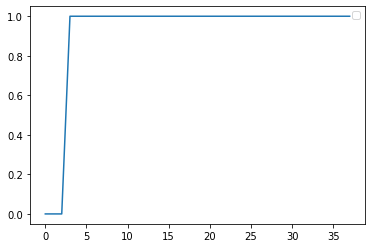

No handles with labels found to put in legend.


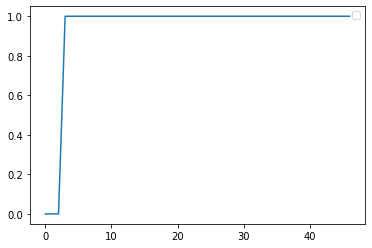

No handles with labels found to put in legend.


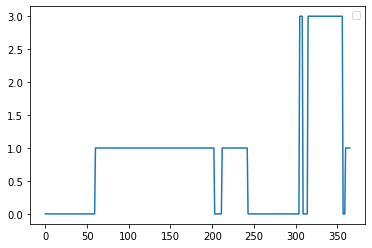

No handles with labels found to put in legend.


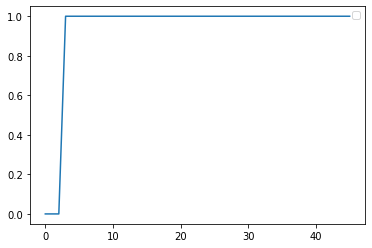

No handles with labels found to put in legend.


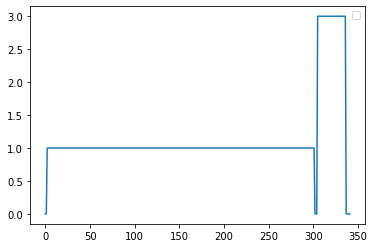

No handles with labels found to put in legend.


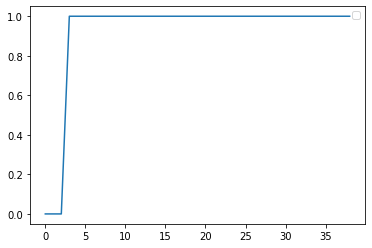

No handles with labels found to put in legend.


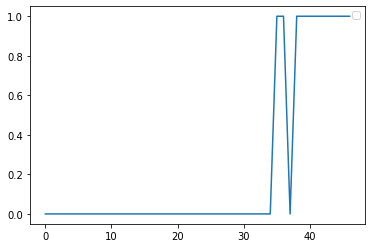

No handles with labels found to put in legend.


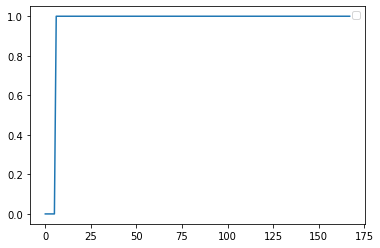

No handles with labels found to put in legend.


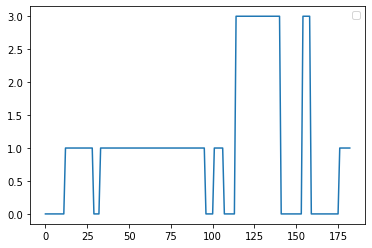

No handles with labels found to put in legend.


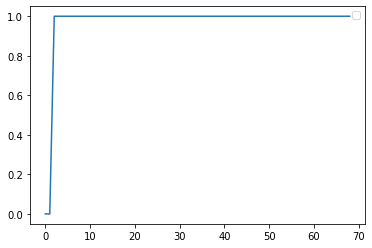

No handles with labels found to put in legend.


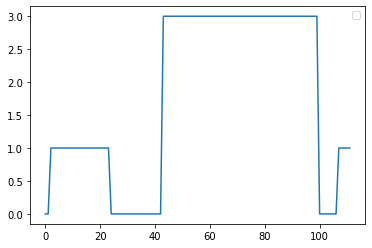

No handles with labels found to put in legend.


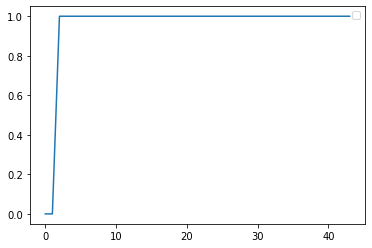

No handles with labels found to put in legend.


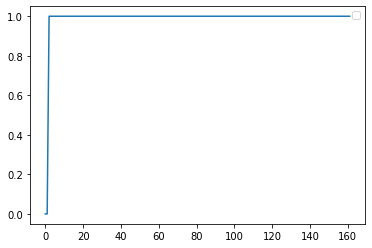

In [26]:
viseme_list, viseme_interval = [viseme_list_final, viseme_intervals_final]

modification_ctrl_pts = []
modification_sliders = []
# iterate through the vowels in the list
dt = 0.01
for i in range(0, len(viseme_list)):
    if viseme_list[i] in VOWELS_SLIDERS_JALI and viseme_interval[i][-2][0] - viseme_interval[i][1][0] > 0.20:
        ##################################################################
        ###################### get the audio signal ######################
        ##################################################################
        vowel_mod_out, vowel_mod_out_coarse = vowel_mod(lyric.sound_arr_interp(np.arange(viseme_interval[i][1][0], 
                                                                                        min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), 1.0/44100.0)))
#         print(["A", "Stretcher", "Rounder", "Silence"][vowel2Cardinal3[viseme_list[i]]])
        xs = np.linspace(viseme_interval[i][1][0], min(viseme_interval[i][-1][0], lyric.snd.xs()[-1]), vowel_mod_out_coarse.shape[0])
        coarse_vowel_sounds_like_interp = interp1d(xs, vowel_mod_out_coarse, axis=0)
        
        
        # what the original sound was
        original_vowel_shape = vowel2Cardinal3[viseme_list[i]]
        only_peaks = np.where(vowel_mod_out_coarse > 0.7, vowel_mod_out_coarse, 0)
        
#         for i in range(0, 4):
#             plt.plot(only_peaks[:, i], label=["A", "Stretcher", "Rounder", "Silence"][i])
            
        plt.plot(np.argmax(only_peaks[:], axis=1))
        plt.legend()
        plt.show()
        
        vowel_sounds_like = np.argmax(only_peaks, axis=1)
        ##################################################################
        ### obtain the intervals of which cardinal vowels are dominant ###
        ##################################################################
        cardinal_list = []
        cardinal_intervals = []
        current_interval_start = 0
        current_vowel = original_vowel_shape
        for t in range(0, vowel_sounds_like.shape[0]):
            if vowel_sounds_like[t] == current_vowel:
                if (t == vowel_sounds_like.shape[0]-1) and current_vowel != 3:
                    cardinal_list.append(current_vowel)
                    cardinal_intervals.append([current_interval_start, t])
            else:
                if xs[t-1] - xs[current_interval_start] >= 0.1:
                    if t > 0 and current_vowel != 3:
                        cardinal_list.append(current_vowel)
                        cardinal_intervals.append([current_interval_start, t-1])
                    current_interval_start = t
                    current_vowel = vowel_sounds_like[t]
        ###########################################################################
        ######### optionally additional smoothing are added to this here ##########      
        ###########################################################################
        cardinal_list_new = []
        cardinal_intervals_new = []
        j = 0
        while j < len(cardinal_list):
            step = 1
            if j == len(cardinal_list) - 1:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            elif cardinal_list[j] == cardinal_list[j+1] and xs[cardinal_intervals[j+1][0]] - xs[cardinal_intervals[j][1]] <= spike_width:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+1][1]])
                step = 2
            elif j < len(cardinal_list) - 2:
                if (cardinal_list[j] == cardinal_list[j+2] and xs[cardinal_intervals[j+2][0]] - xs[cardinal_intervals[j][1]] <= spike_width 
                    and cardinal_list[j+1] == original_vowel_shape):
                    cardinal_list_new.append(cardinal_list[j])
                    cardinal_intervals_new.append([cardinal_intervals[j][0], cardinal_intervals[j+2][1]])
                    step = 3
            else:
                cardinal_list_new.append(cardinal_list[j])
                cardinal_intervals_new.append(cardinal_intervals[j])
            j = j + step
        cardinal_list = cardinal_list_new
        cardinal_intervals = cardinal_intervals_new
#         print(cardinal_list, cardinal_intervals)
        # now set pucker/stretch values based on the detected sound
        ctrl_pts = []
        for c in range(0, len(cardinal_list)):
            if original_vowel_shape == cardinal_list[c] or cardinal_list[c] == 3:
                continue
            else:
                max_prob = coarse_vowel_sounds_like_interp(xs[cardinal_intervals[c][0]:cardinal_intervals[c][1]+1])[:, cardinal_list[c]].max()
                
#                 print(original_vowel_shape, cardinal_list[c], max_prob)
                slider_ct_pts = control_direction_matrix_coarse[original_vowel_shape][cardinal_list[c]]
                for s in range(0, int(len(slider_ct_pts)/3)):
                    # get the name and attribute of the slider
                    slider_name = slider_ct_pts[0 + 3*s]
                    if slider_name == "self":
                        slider_name = viseme_list[i]
                    slider_attribute = slider_ct_pts[1 + 3*s]
                    
                    # add a starting keyframe and ending keyframe
                    modification_sliders.append([slider_name, slider_attribute])
                    # the start of this curve should be earlier, e.g. at 75% of the previous interval
                    # however, if the detected modification is at the very beginning of the vowel, then it is
                    # applied the same time as the beginning of the vowel
                    same_start = False
                    if c == 0: 
#                         start_candidate = xs[cardinal_intervals[c][0]]-0.14
#                         start = max(start_candidate, viseme_interval[i][0][0])
                        start = viseme_interval[i][0][0]
                        same_start = True
                    else:
                        start_candidate = (xs[cardinal_intervals[c-1][1]] - xs[cardinal_intervals[c-1][0]]) * 0.6 + xs[cardinal_intervals[c-1][0]]
                        start_candidate = min(start_candidate, xs[cardinal_intervals[c-1][1]]-0.12)
                        start = max(start_candidate, xs[cardinal_intervals[c-1][0]])
                        if np.abs(start - viseme_interval[i][1][0]) <= 0.2:
                            start = viseme_interval[i][0][0]
                            same_start = True
                    ctrl_pts.append([start, 0])
                    # add the end point of the curve. This would either at the end of the 
                    # prediction interval, or at the end of the vowel. 
#                     modification_sliders.append([slider_name, slider_attribute])
                    if c == len(cardinal_list) - 1:
                        ctrl_pts.append([xs[cardinal_intervals[c][1]], 0])
                    else:
                        ctrl_pts.append([viseme_interval[i][-1][0], 0])        
                    # add the peaks in the middle with the decay
                    slider_range = slider_ct_pts[2 + 3*s]
#                     modification_sliders.append([slider_name, slider_attribute])
                    # with some anticipation 
                    if same_start:
                        ctrl_pts.append([viseme_interval[i][1][0], max_prob * (slider_range[1])])
                    else:
                        ctrl_pts.append([xs[cardinal_intervals[c][0]]-0.13, max_prob * (slider_range[1])])
#                     modification_sliders.append([slider_name, slider_attribute])
                    end_p75 = (xs[cardinal_intervals[c][1]] - xs[cardinal_intervals[c][0]]) * 0.75 + xs[cardinal_intervals[c][0]]
                    ctrl_pts.append([end_p75, max_prob * (slider_range[1]) * 0.75])
                    modification_ctrl_pts.append(ctrl_pts)

## 2.2 smooth out un-intended artifacts due to unexpected overlaps

In [18]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(list(jali_sets.vocabs))):
    prev_slider_dict[list(jali_sets.vocabs)[i]] = -1
viseme_list_final_final = []
viseme_intervals_final_final = []
i = 0  
while i < len(viseme_list_final):
    increment = 1
    prev_viseme = viseme_list_final[i]
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[viseme_list_final[i]] != -1:
        current_interval = viseme_intervals_final[i]
        prev_interval = viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]]
        if (current_interval[1][0] >= prev_interval[2][0] and current_interval[0][0] <= prev_interval[3][0]):
            interval = prev_interval[:-1] + current_interval[1:]
            viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]] = interval
        elif (current_interval[1][0] <= prev_interval[2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            viseme_intervals_final_final[prev_slider_dict[viseme_list_final[i]]] = interval
        else:
            viseme_list_final_final.append(viseme_list_final[i])
            viseme_intervals_final_final.append(viseme_intervals_final[i])
                
    else:        
        viseme_list_final_final.append(viseme_list_final[i])
        viseme_intervals_final_final.append(viseme_intervals_final[i])
        
    prev_slider_dict[viseme_list_final[i]] = len(viseme_list_final_final) - 1
    i = i + increment

In [328]:
print(modification_sliders_final)
print()

[['U_pointer', 'Lip Pucker'], ['U_pointer', 'Lip Pucker'], ['U_pointer', 'Lip Pucker'], ['Dimple', 'Dimple'], ['Dimple', 'Dimple']]


In [329]:
# pass 3
# set this up
prev_slider_dict = {}
for i in range(0, len(modification_sliders)):
    prev_slider_dict[modification_sliders[i][0] + "_" + modification_sliders[i][1]] = -1
modification_sliders_final = []
modification_ctrl_pts_final = []
i = 0  
while i < len(modification_sliders):
    increment = 1
    prev_viseme = modification_sliders[i][0] + "_" + modification_sliders[i][1]
    # if the previous instance of the current viseme is not -1
    if prev_slider_dict[prev_viseme] != -1:
        current_interval = modification_ctrl_pts[i]
        current_interval.sort(key=lambda x:x[0])
        prev_interval = modification_ctrl_pts[prev_slider_dict[prev_viseme]]
        prev_interval.sort(key=lambda x:x[0])
        # if there is a weird insertion
        if (current_interval[1][0] >= prev_interval[2][0] and current_interval[0][0] <= prev_interval[3][0]):
            interval = prev_interval[:-1] + current_interval[1:]
            modification_ctrl_pts_final[prev_slider_dict[prev_viseme]] = interval
        elif (current_interval[1][0] <= prev_interval[2][0]):
            interval = prev_interval[0:-2] + current_interval[1:]
            modification_ctrl_pts_final[prev_slider_dict[prev_viseme]] = interval
        else:
            modification_sliders_final.append(modification_sliders[i])
            modification_ctrl_pts_final.append(modification_ctrl_pts[i])
                
    else:        
        modification_sliders_final.append(modification_sliders[i])
        modification_ctrl_pts_final.append(modification_ctrl_pts[i])
        
    prev_slider_dict[modification_sliders[i][0] + "_" + modification_sliders[i][1]] = len(modification_sliders_final) - 1
    i = i + increment

In [330]:
modification_ctrl_pts = []
modification_sliders = []
for i in range(0, len(modification_ctrl_pts_final)):
    for j in range(0, len(modification_ctrl_pts_final[i])):
        modification_sliders.append(modification_sliders_final[i])
        modification_ctrl_pts.append(modification_ctrl_pts_final[i][j])
        

In [331]:
lyric.compute_self_vibrato_intervals()
vib_ctrl_pts = []
# for k in lyric.vibrato_intervals:
#     if len(k) > 0:
#         for m in k:
#             vib_ctrl_pts.append(m)


11.970000000000002
11.891315789473687
11.950000000000001
11.79263157894737
11.940000000000001
11.693947368421055
11.920000000000002
11.595263157894738
11.8
11.496578947368423
11.780000000000001
11.397894736842106
11.760000000000002
11.299210526315791
11.700000000000001
11.200526315789475
11.500000000000002
11.10184210526316
11.420000000000002
11.003157894736844
11.290000000000001
10.904473684210528
11.21
10.805789473684213
11.090000000000002
10.707105263157896
11.030000000000001
10.60842105263158
10.910000000000002
10.509736842105264
10.810000000000002
10.411052631578949
10.8
10.312368421052632
10.730000000000002
10.213684210526317
10.660000000000002
10.115
10.640000000000002
10.016315789473685
10.620000000000001
9.91763157894737
10.600000000000001
9.818947368421053
10.55
9.720263157894738
10.490000000000002
9.621578947368421
10.46
9.522894736842106
10.450000000000001
9.424210526315791
10.440000000000001
9.325526315789475
10.410000000000002
9.226842105263158
10.340000000000002
9.128157

## 2.3 Create additional overlap between vowels so it's smoother

In [332]:
# for i in range(1, len(viseme_list)):
#     # re-order all the clips so that 
#     if pure_phoneme_list[i] in cmu_sets.vowels:
#         prev_vowel = -1
#         for si in range(i-1, -1, -1):
#             if pure_phoneme_list[si] in cmu_sets.vowels:
#                 prev_vowel = si
#                 break
#         if prev_vowel > -1 and viseme_list[i] != viseme_list[prev_vowel]:
#             interval_i = viseme_intervals[i]
#             interval_i.sort(key=lambda x:x[0])
#             interval_prev = viseme_intervals[prev_vowel]
#             interval_prev.sort(key=lambda x:x[0])
#             if interval_i[0][0] <= interval_prev[-1][0]:
#                 # there is an overlap
#                 interval_prev[-2][0] = interval_i[1][0]
#                 interval_prev[-1][0] = interval_i[1][0] + 0.12
#                 viseme_intervals[prev_vowel] = interval_prev

## 4. Output results

In [333]:
output ={"viseme":[viseme_list_final_final, viseme_intervals_final_final],
#         "brow":[brow_movement, brow_ctrl_points, finer_brow_raise_ctrl_points, finer_brow_furrow_ctrl_points],
#         "blink":[eye_movement, eye_ctrl_points],
        "vowel_mod": [modification_sliders, modification_ctrl_pts],
        "jaw":[[0, 6]],
        "lip":[[0, 6]], 
        "vib":vib_ctrl_pts}
jsonoutput = json.dumps(output)
with open(os.path.join(dir, file_name_template + "_" + output_template + '.json'), 'w') as outfile:
    json.dump(jsonoutput, outfile)